## Debiasing Galaxy Zoo Data

`Morphological Classification of Galaxy Images from the GAMA-KiDS Survey Using Galaxy Zoo`

This notebook de-biases a reduced Galaxy Zoo dataset.

In [1]:
# imports
import os
import sys
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter as counter
from scipy.ndimage import gaussian_filter as gauss
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import pandas as pd
import imageio
import time

# Notebook Startup
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}   # removes notebook figure transparencies
print(f'Notebook run time: \n   {time.ctime()}')

Notebook run time: 
   Mon Jun  1 21:45:23 2020


In [16]:
# Import the required packages #################################################
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from calc_kcor import calc_kcor
import os
import numpy as np
import math

cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # Use standard cosmology model from astropy.

data_file = 'full_sample.fits'
data_dir = './'
save_dir = './'
fig_dir = './'

In [17]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

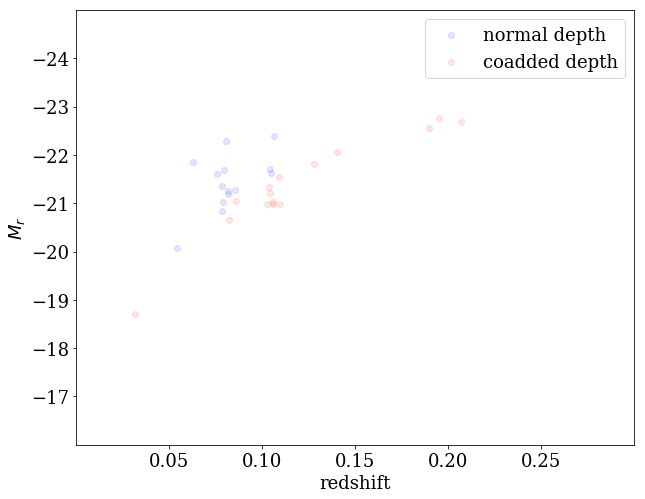

In [18]:
full = Table.read(data_dir + data_file)

remove_low_z = full['REDSHIFT_1'] >= 0.03 # remove low redshift
full = full[remove_low_z]

s82_select = np.array(['coadd' in s for s in full['sample']]).T
normal_depth = s82_select == False

plt.scatter(full[normal_depth]['REDSHIFT_1'],full[normal_depth]['PETROMAG_MR'],alpha=0.1,color='blue'
            ,label='normal depth')
plt.scatter(full[normal_depth == False]['REDSHIFT_1'],full[normal_depth == False]['PETROMAG_MR']
            ,alpha=0.1,color='red',label='coadded depth')
plt.legend()
plt.xlim(0,0.3)
plt.ylim(-16,-25)
plt.xlabel('redshift')
plt.ylabel('$M_r$')
# Can see here that stripe 82 goes below the m_r=17 selection limit.

full = full[normal_depth] # only keep the normal depth images.

In [19]:
def get_sample_limits(z,table):
    
    z_max=[z] # Define the maximum redshift.
    D_max=(10**6)*(np.array(cosmo.luminosity_distance(z_max))[0]) # Define the
    # maximum distance from the max redshift.
    m_limit=17 # Maximum apparent magnitude to be used to cut the sample.
    k_val = calc_kcor('r',z,'g - r',0.8)
    M_limit=m_limit - 5*(math.log10(D_max) - 1) - k_val

    return z_max,M_limit

In [20]:
def output_vls_sizes(table,N_steps=1000,z_min=0.03):
    
    z_vals = np.linspace(np.min(table['REDSHIFT_1']),np.max(table['REDSHIFT_1']),N_steps)
    # Replace the value closest to 0.085 with the exact value 
    # (as it is a 'special' value where we have environment data)
    z_vals[find_nearest(z_vals,0.085)] = 0.085
    sizes=np.zeros((N_steps,2))

    for z in enumerate(z_vals):
        z_max,M_limit = get_sample_limits(z=z[1],table=table)
        select = ((table['PETROMAG_MR'] <= M_limit) & (table['REDSHIFT_1'] <= z_max) 
                  & (table['REDSHIFT_1'] >= z_min))# & (table['mag'] <= 17))
        sizes[z[0],:] = np.array([z[1],np.sum(select)])
  
    sizes = Table(sizes,names=('redshift','N_gal'))
        
    return sizes

In [21]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def plot_line(max_sample,style,label):
    lines=np.array([[0,max_sample[0],max_sample[0]],[max_sample[1],max_sample[1],0]])
    plt.plot(lines[0],lines[1],style,label=label,linewidth=2)
    return None

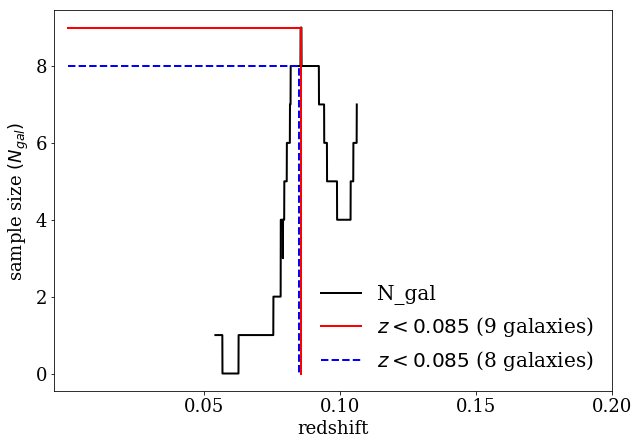

In [22]:
plt.figure(figsize=(10,7))
styles=["b--","g:"]

sizes=output_vls_sizes(table=full,N_steps=1000)
plt.plot(sizes['redshift'],sizes['N_gal'],"k-",linewidth=2)

max_sample=sizes[np.argmax(sizes['N_gal'])]
plot_line(max_sample,"r-",label="$z<{0:.3f}$".format(max_sample[0]) 
          + " ({0:.0f} galaxies)".format(max_sample[1]))

for z in enumerate([0.085]):
    max_sample=sizes[find_nearest(array=sizes['redshift'],value=z[1])]
    plot_line(max_sample,styles[z[0]],label="$z<{0:.3f}$".format(max_sample[0]) 
              + " ({0:.0f} galaxies)".format(max_sample[1]))
    
plt.xlabel('redshift')
plt.ylabel('sample size $(N_{gal})$')
plt.xticks(np.arange(0.05,0.25,0.05))
plt.legend(fontsize=20,frameon=False)

os.mkdir(fig_dir) if os.path.isdir(fig_dir) is False else None
plt.savefig(fig_dir + 'sample_sizes.pdf')